In [2]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
from scipy import stats
import statsmodels.api as sm
import numpy as np
import json
from tqdm import tqdm_notebook 
import statsmodels.formula.api as smf

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read the Data

In [3]:
second_session_raw_data = pd.read_csv('Data/gono-go-game-second-round.csv', index_col=0).reset_index()
# second_session_raw_data = second_session_raw_data[second_session_raw_data.recorded_at > '2022-01-18']
# second_session_raw_data = second_session_raw_data[second_session_raw_data.mturkID != 'nan' ]

num_all_experimenters = len(second_session_raw_data.mturkID.unique())
num_excluded_experimenters = 0

second_session_raw_data['correct'] = second_session_raw_data.correct == 'true'

# second_session_raw_data.head()

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
len(second_session_raw_data.mturkID.value_counts())

135

In [5]:
# raw_demographic_data = second_session_clean_data[second_session_clean_data.trial_type == 'survey-html-form'][['mturkID', 'response']]
raw_demographic_data = second_session_raw_data[(second_session_raw_data.response != "") & (second_session_raw_data.trial_type == 'survey-html-form')][['mturkID', 'response']].drop_duplicates(subset=['mturkID'], keep='last')

raw_demographic_data['gender'] = raw_demographic_data.response.apply(lambda x: x.split('"')[3])
raw_demographic_data['age'] = raw_demographic_data.response.apply(lambda x: x.split('"')[7])
raw_demographic_data['education_level'] = raw_demographic_data.response.apply(lambda x: x.split('"')[11])
raw_demographic_data['comments'] = raw_demographic_data.response.apply(lambda x: x.split('"')[15])
raw_demographic_data = raw_demographic_data.drop(['response'], axis=1)
# raw_demographic_data.shape

In [6]:
raw_demographic_data.gender.value_counts()

male      77
female    50
other      4
Name: gender, dtype: int64

# Apply exclusion criteria

1. Fail the quiz of instructions more than twice.
2. Change the tab or window of the experiment.

In [7]:
experimenter_status = second_session_raw_data[second_session_raw_data.trial_type == 'survey-html-form'][['run_id','mturkID', 'exp_final_status']]
IDs_for_inclusion_by_completed = experimenter_status[experimenter_status.exp_final_status == 'fully_completed'].mturkID

run_IDs_for_exclusion_by_changing_tabs = second_session_raw_data[second_session_raw_data.exp_final_status == 'not_completed_by_changing_tab'].run_id
run_IDs_for_exclusion_by_failing_quiz = second_session_raw_data[second_session_raw_data.exp_final_status == 'not_completed_by_failing_quiz'].run_id

second_session_clean_data = second_session_raw_data[second_session_raw_data.run_id.isin(run_IDs_for_exclusion_by_changing_tabs) == False]
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id.isin(run_IDs_for_exclusion_by_failing_quiz) == False]



num_excluded_experimenters = len(second_session_raw_data.mturkID.unique()) - len(second_session_clean_data.mturkID.unique())

print("Number of participants excluded by this criterias:", num_excluded_experimenters)

Number of participants excluded by this criterias: 4


In [8]:
# exclude the first try of a turker
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id != 204 ]
second_session_clean_data = second_session_clean_data[second_session_clean_data.run_id != 14]
second_session_clean_data.mturkID.replace({"A2TLN8489YGY81_agaign": "A2TLN8489YGY81"}, inplace=True)


In [9]:
second_session_clean_data.mturkID.isna().sum()

0

3. Respond randomly, always go or never go.

    * Note: We exclude who repond randomly, always go or nogo in each 3 block

In [10]:
susp = second_session_clean_data[second_session_clean_data.suspicious == 'true'][['mturkID', 'suspicious_type','num_gos', 'block']]

In [11]:
IDs_for_exclusion_by_random_response = list(susp.mturkID.value_counts()[ (susp.mturkID.value_counts() == 3) | (susp.mturkID.value_counts() == 2) ].index)

num_excluded_experimenters += len(IDs_for_exclusion_by_random_response)

second_session_clean_data = second_session_clean_data[second_session_clean_data.mturkID.isin(IDs_for_exclusion_by_random_response) == False]

print("Number of participants excluded by this criterias:", len(IDs_for_exclusion_by_random_response))


Number of participants excluded by this criterias: 5


In [12]:
second_session_clean_data.mturkID.isna().sum()

0

In [13]:
second_session_clean_data.mturkID.unique().shape

(125,)

4. Their rate of the correct response to detection of circle side task is less than 55%.

In [14]:
circle_side_correctness = second_session_clean_data[second_session_clean_data.choice == 'go'][['mturkID','side', 'response']]
circle_side_correctness['is_correct_circle_side'] =  (circle_side_correctness.side == circle_side_correctness.response)
accuracy_data = circle_side_correctness.groupby('mturkID').mean().reset_index()
accuracy_data.columns = ['mturkID', 'rate']
accuracy_data['is_below_55'] = accuracy_data.rate < 0.55

# accuracy_data.head()


In [15]:
non_accurate_IDs = list(accuracy_data[accuracy_data.is_below_55 == True].mturkID)

num_excluded_experimenters += len(non_accurate_IDs)

second_session_clean_data = second_session_clean_data[second_session_clean_data.mturkID.isin(list(non_accurate_IDs)) == False]
print("Number of participants excluded by this criterias:", len(non_accurate_IDs))



Number of participants excluded by this criterias: 11


In [16]:
second_session_clean_data.mturkID.isna().sum()

0

In [17]:
second_session_clean_data[second_session_clean_data.mturkID.isna()].run_id.unique()

array([], dtype=int64)

In [18]:
second_session_clean_data.mturkID.unique().shape

(114,)

# Plot Perforance per conditions

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_17274/337833352.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)


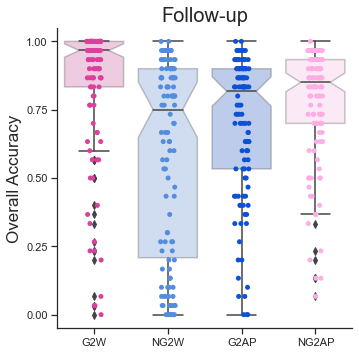

In [25]:
mapping = {'1': 'G2W', '2': 'NG2W', '3': 'G2AP', '4' : 'NG2AP'} 

circle_task_logs = second_session_clean_data[second_session_clean_data.exp_stage == 'main_target_detection']

circle_task_logs['correct_action'] = (circle_task_logs.choice == circle_task_logs.cond_action)
performance_per_condition = circle_task_logs.groupby(['mturkID','cond']).mean().reset_index()
performance_per_condition.cond = performance_per_condition.cond.map(mapping)


ax = sns.catplot(x="cond", y="correct", data=performance_per_condition, 
                    order= ['G2W','NG2W' ,'G2AP', 'NG2AP'], alpha = 1,
                    palette= ["#DD409C","#538DDF","#0C52D4","#FFADE5"]
                    );
ax = sns.boxplot(x="cond", y="correct", data= performance_per_condition , 
                    boxprops=dict(alpha=.3), notch =True, 
                    order= ['G2W','NG2W' ,'G2AP', 'NG2AP'],
                    palette= ["#DD409C","#538DDF","#0C52D4","#FFADE5"]
                    );

ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.set(xlabel="", ylabel = "", title = 'Follow-Up Session')
ax.set_ylabel('Overall Accuracy', fontsize=17)
ax.set_title('Follow-up', fontsize = 20)

plt.show()


In [19]:
def extract_action(x):
    if('nogo2avoidPun' in x):
        return 'nogo'
    elif('nogo2win' in x):
        return 'nogo'
    elif( 'go2avoidPun' in x):
        return 'go'
    elif( 'go2win' in x):
        return 'go'
    else:
        return 'error'

def extract_outcome(x):
    if('nogo2avoidPun' in x):
        return 'avoidPun'
    elif('nogo2win' in x):
        return 'win'
    elif( 'go2avoidPun' in x):
        return 'avoidPun'
    elif( 'go2win' in x):
        return 'win'
    else:
        return 'error'


performance_for_anova = pd.DataFrame()
performance_for_anova['action'] = performance_per_condition.cond.apply(lambda x: extract_action(x))
performance_for_anova['outcome'] = performance_per_condition.cond.apply(lambda x: extract_outcome(x))
performance_for_anova['performance'] = performance_per_condition.correct

In [20]:
model = smf.ols('performance ~ C(outcome) + C(action) +\
C(outcome):C(action)',
            data=performance_for_anova).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
(result)

,df,sum_sq,mean_sq,F,PR(>F)
C(outcome),1.0,0.050526,0.050526,0.670846,4.131884e-01
C(action),1.0,0.930614,0.930614,12.355916,4.839266e-04
C(outcome):C(action),1.0,3.244922,3.244922,43.083366,1.441392e-10
Residual,452.0,34.043411,0.075317,NaN,NaN


In [21]:
my_model_fit = smf.ols("performance ~ outcome * action ", performance_for_anova).fit()
# print summary of linear regression
# print(my_model_fit.summary())
# show anova table
print(sm.stats.anova_lm(my_model_fit, typ=2))

                   sum_sq     df          F        PR(>F)
outcome          0.050526    1.0   0.670846  4.131884e-01
action           0.930614    1.0  12.355916  4.839266e-04
outcome:action   3.244922    1.0  43.083366  1.441392e-10
Residual        34.043411  452.0        NaN           NaN


# Extract Demographic datas

In [22]:
len(raw_demographic_data.mturkID.unique())

131

In [23]:
# raw_demographic_data = second_session_clean_data[second_session_clean_data.trial_type == 'survey-html-form'][['mturkID', 'response']]
raw_demographic_data = second_session_clean_data[(second_session_clean_data.response != "") & (second_session_raw_data.trial_type == 'survey-html-form')][['mturkID', 'response']].drop_duplicates(subset=['mturkID'], keep='last')

raw_demographic_data['gender'] = raw_demographic_data.response.apply(lambda x: x.split('"')[3])
raw_demographic_data['age'] = raw_demographic_data.response.apply(lambda x: x.split('"')[7])
raw_demographic_data['education_level'] = raw_demographic_data.response.apply(lambda x: x.split('"')[11])
raw_demographic_data['comments'] = raw_demographic_data.response.apply(lambda x: x.split('"')[15])
raw_demographic_data = raw_demographic_data.drop(['response'], axis=1)
# raw_demographic_data.shape

/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20331/3402330953.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  raw_demographic_data = second_session_clean_data[(second_session_clean_data.response != "") & (second_session_raw_data.trial_type == 'survey-html-form')][['mturkID', 'response']].drop_duplicates(subset=['mturkID'], keep='last')


In [24]:
raw_demographic_data.age.apply(int).quantile(0.75)

46.0

In [25]:
raw_demographic_data.education_level.value_counts()

Bachelor     60
High         26
Associate    20
Master        6
lessHigh      2
Name: education_level, dtype: int64

In [26]:
circle_task_logs['cond'] = circle_task_logs.cond_action + '2' + circle_task_logs.cond_outcome 
GOs = (circle_task_logs[circle_task_logs.choice == 'go'].groupby(['mturkID']).count()['run_id'].rename('second_num_GOs'))
noGos = (circle_task_logs[circle_task_logs.choice == 'nogo'].groupby(['mturkID']).count()['run_id'].rename('second_num_noGos'))
go2win_Gos = (circle_task_logs[(circle_task_logs.choice == 'go') & (circle_task_logs.cond == 'go2win')].groupby(['mturkID']).count()['run_id'].rename('second_num_go2win_Gos'))
nogo2avoidpun_noGos = (circle_task_logs[(circle_task_logs.choice == 'nogo') & (circle_task_logs.cond == 'nogo2avoidPun')].groupby(['mturkID']).count()['run_id'].rename('second_num_nogo2avoidPun_noGos'))
new_pav_metric_df = pd.concat([GOs, noGos, go2win_Gos, nogo2avoidpun_noGos], axis=1)


/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20331/4121152230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circle_task_logs['cond'] = circle_task_logs.cond_action + '2' + circle_task_logs.cond_outcome


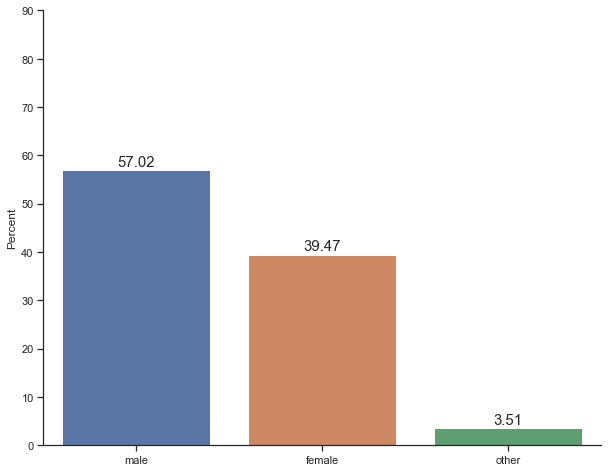

In [27]:
plt.figure(figsize=(10,8))
plt.ylabel("Percent")
gender_percent = (raw_demographic_data.gender.value_counts(normalize=True))*100
gender_percent[0]
ax = sns.barplot(y = gender_percent,x = gender_percent.index)
ax.set_yticks(np.arange(0, 100, 10));
ax.set_ylabel("Percent");

for bar in ax.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()


In [28]:
sum_age = []
for i in (raw_demographic_data.age):
    try:
        sum_age.append(int(i))
    except:
        print("ERRRR")
np.mean(sum_age)

39.24561403508772

# Create final data to analyze

In [29]:
final_performace_data = performance_per_condition.pivot(index='mturkID', columns='cond', values='correct').reset_index()


final_performace_data = pd.merge(final_performace_data, accuracy_data, on='mturkID')
final_performace_data = pd.merge(final_performace_data, raw_demographic_data, on='mturkID')
final_performace_data.columns = ['mturkID', 'go2avoidPun_second_session', 'go2win_second_session', 'nogo2avoidPun_second_session', 'nogo2win_second_session', 'circle_side_performance_second_session',\
       'is_below_55_second_session', 'gender_second_session', 'age_second_session', 'education_level_second_session', 'comments_second_session']
overall_performance =  final_performace_data['nogo2win_second_session'] + \
                        final_performace_data['go2win_second_session'] + \
                        final_performace_data['nogo2avoidPun_second_session'] + \
                        final_performace_data['go2avoidPun_second_session']
final_performace_data['overall_performance'] = overall_performance/4

final_performace_data = final_performace_data.merge(new_pav_metric_df, on='mturkID', how='left')

final_performace_data.head()

,mturkID,go2avoidPun_second_session,go2win_second_session,nogo2avoidPun_second_session,nogo2win_second_session,circle_side_performance_second_session,is_below_55_second_session,gender_second_session,age_second_session,education_level_second_session,comments_second_session,overall_performance,second_num_GOs,second_num_noGos,second_num_go2win_Gos,second_num_nogo2avoidPun_noGos
0,A10BH9PYCYUKDJ,0.500000,0.8,0.600000,0.266667,1.000000,False,female,41,Associate,},0.541667,73,47,24.0,18
1,A10JXOU89D5RXR,0.900000,1.0,0.900000,0.700000,0.986667,False,female,60,Bachelor,},0.875000,69,51,30.0,27
2,A11S8IAAVDXCUS,0.200000,1.0,0.633333,0.133333,1.000000,False,female,31,Associate,},0.491667,73,47,30.0,19
3,A12FTSX85NQ8N9,0.866667,1.0,0.966667,0.866667,1.000000,False,male,29,Bachelor,},0.925000,61,59,30.0,29
4,A12HZGOZQD5YK7,0.966667,1.0,0.966667,0.800000,1.000000,False,female,41,Associate,},0.933333,66,54,30.0,29


In [30]:
final_performace_data.shape

(114, 16)

In [31]:
final_performace_data.drop_duplicates().to_csv('Data/second_round_final_performance.csv')

# Pav axis

(0.0, 1.0)

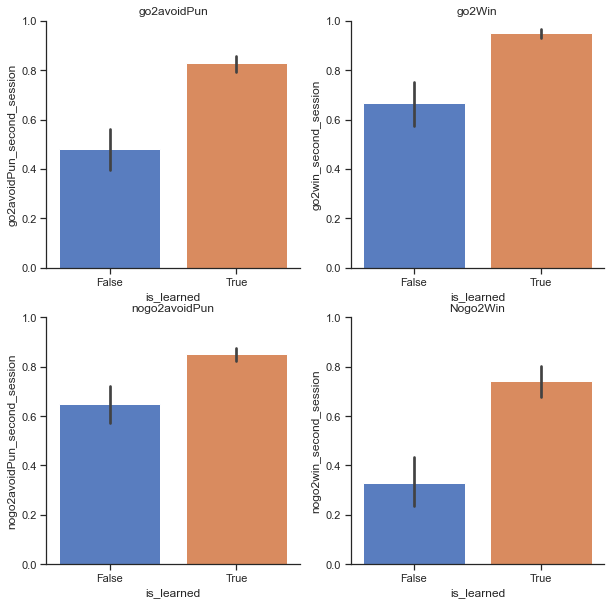

In [32]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(10,10))
plt.ylim(0, 1)

final_performace_data['is_learned'] = final_performace_data.overall_performance > 0.65

sns.barplot(x="is_learned", y="nogo2win_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,1)]).set_title('Nogo2Win')

axs[1,1].set_ylim(0,1)

sns.barplot(x="is_learned", y="go2win_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,1)]).set_title('go2Win')
axs[0,1].set_ylim(0,1)



sns.barplot(x="is_learned", y="go2avoidPun_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(0,0)]).set_title('go2avoidPun')
axs[0,0].set_ylim(0,1)



sns.barplot(x="is_learned", y="nogo2avoidPun_second_session", 
 data=final_performace_data,
 palette="muted", ax = axs[(1,0)]).set_title('nogo2avoidPun')
axs[1,0].set_ylim(0,1)




# modelling

In [33]:
result_of_trials = circle_task_logs[['mturkID', 'internal_node_id', 'response', 'side', 'choice', 'cond_action', 'cond_outcome','correct_action', 'outcome', 'feedback_points', 'block']].copy()

result_of_trials['stimulus'] = result_of_trials['cond_action'] + '2' + result_of_trials['cond_outcome']
result_of_trials['is_go'] = result_of_trials.choice == 'go'
result_of_trials['is_go'].replace({True: 1, False: 0}, inplace=True)


In [34]:
result_of_trials[['mturkID','choice', 'feedback_points', 'stimulus']].to_csv('data_for_modeling_matlab_second_session.csv')

In [35]:
result_of_trials.to_csv('Data/second_round_result_of_trials.csv')

In [36]:
go2win_go_prob = pd.Series(np.zeros(30))
go2win_prob_df = pd.DataFrame()

nogo2win_go_prob = pd.Series(np.zeros(30))
nogo2win_prob_df = pd.DataFrame()

go2avoidPun_go_prob = pd.Series(np.zeros(30))
go2avoidPun_prob_df = pd.DataFrame()

nogo2avoidPun_go_prob = pd.Series(np.zeros(30))
nogo2avoidPun_prob_df = pd.DataFrame()




for mID in result_of_trials.mturkID.dropna().unique():
    go_of_every_subject = result_of_trials[result_of_trials['mturkID']== mID][['is_go','stimulus']].reset_index(drop=True)
    for s in ['go2win','nogo2win','go2avoidPun', 'nogo2avoidPun']:
        go_of_every_subject_in_s = go_of_every_subject[go_of_every_subject.stimulus == s].reset_index(drop=True)
        if( s == 'go2win'):
            go2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2win'):
            nogo2win_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'go2avoidPun'):
            go2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            go2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
        elif (s == 'nogo2avoidPun'):
            nogo2avoidPun_go_prob += go_of_every_subject_in_s.is_go/len(result_of_trials.mturkID.dropna().unique())
            nogo2avoidPun_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()


/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20331/3190507868.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  go2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20331/3190507868.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  nogo2win_prob_df[mID] = go_of_every_subject_in_s.is_go.copy()
/var/folders/5p/j5wvkpqj2_n5r5h100pdscbr0000gn/T/ipykernel_20331/3190507868.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

(0.0, 1.0)

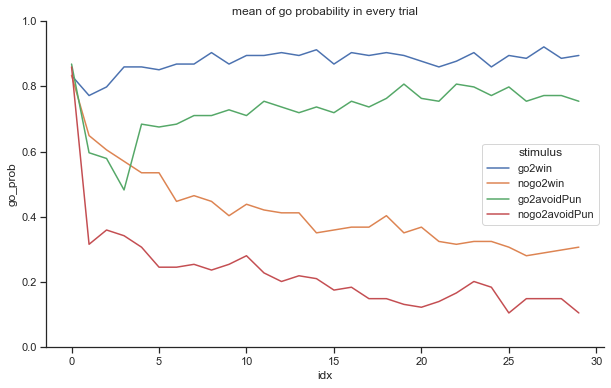

In [37]:
go_prob_df = pd.DataFrame({'go2win': go2win_go_prob, 
                            'nogo2win': nogo2win_go_prob,
                            'go2avoidPun': go2avoidPun_go_prob,\
                            'nogo2avoidPun': nogo2avoidPun_go_prob})

# go_prob_df['idx'] = go_prob_df.index

go_prob_df = go_prob_df.melt().rename(columns={'variable': 'stimulus', 'value': 'go_prob'})
go_prob_df.loc[go_prob_df.stimulus == 'go2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2win', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'go2avoidPun', 'idx'] = range(0,30) 
go_prob_df.loc[go_prob_df.stimulus == 'nogo2avoidPun', 'idx'] = range(0,30)

plt.figure(figsize=(10,6))
ax = sns.lineplot(x="idx", y="go_prob",
             hue="stimulus", 
             data=go_prob_df)
plt.title("mean of go probability in every trial")
plt.ylim(0,1)

 

In [38]:
from sys import path
from dotenv import load_dotenv
import os
load_dotenv();

path.append(os.environ.get("MODELING_PATH"))

from fitting import ML

In [39]:
np.random.seed(30)
modeling_result_df = {}
modeling_result_df['mturkID'] = []

modeling_result_df['alpha'] = []
modeling_result_df['beta'] = []
modeling_result_df['noise'] = []
modeling_result_df['go_bias'] = []
modeling_result_df['pav_bias'] = []


def fit_subject_with_id(subject_id):
    df = result_of_trials[result_of_trials.mturkID == subject_id]
    df = df[['choice','stimulus','feedback_points']].rename(columns={'choice':'action', 'feedback_points':'reward'}).reset_index(drop=True)
    df['reward'] = pd.to_numeric(df.reward)

    max_likelihood = ML(df, optimization_method='Nelder-Mead', model_type='RW+noise+bias+Pav', initial_guess=np.random.normal(0,1,1)[0]*np.array([0.1,0.1,0.1,0.1,0.1]), without_bound=True)
    res = max_likelihood.fit_model()
    return res



In [40]:
# for subject in tqdm_notebook(result_of_trials.mturkID.unique()):
#     res = fit_subject_with_id(subject)

#     modeling_result_df['mturkID'].append(subject)
#     modeling_result_df['alpha'].append(1 / (1+ np.exp(-res.x[0])))
#     modeling_result_df['beta'].append(np.exp(res.x[1]))
#     modeling_result_df['noise'].append(1 / (1+ np.exp(-res.x[2])))
#     modeling_result_df['go_bias'].append(res.x[3])
#     modeling_result_df['pav_bias'].append(np.exp(res.x[4]))




In [41]:
# mr_df = pd.DataFrame(modeling_result_df)
# mr_df['pav_bias_log'] = np.log(mr_df.pav_bias)

In [42]:
# mr_df.to_csv('./Data/modeling_result_second_session.csv')
mr_df = pd.read_csv("result_of_modeling_matlab_second_session.csv")


In [43]:
mr_df

,mturkID,alpha,beta_rew,beta_pun,noise,bias,pav
0,A10BH9PYCYUKDJ,0.551227,1.870221,1.053401,0.959794,0.662219,0.779801
1,A10JXOU89D5RXR,0.412565,15.178943,6.129252,0.980676,0.090129,1.296948
2,A11S8IAAVDXCUS,0.071892,8.704185,0.768169,0.967854,0.682982,1.808994
3,A12FTSX85NQ8N9,0.425205,30.349657,8.326456,0.981851,1.226812,3.517293
4,A12HZGOZQD5YK7,0.833290,6.096610,5.602220,0.979218,1.444383,0.868345
5,A12X8RUSITV7RU,0.463235,14.876242,7.001601,0.980821,0.022230,1.384434
6,A136K4YZY2OFTV,0.392600,27.995251,11.275108,0.983656,1.281831,1.117288
7,A14W0AXTJ3R19V,0.214122,5.947264,7.198534,0.973615,1.261445,0.595965
8,A173MXK429XAZQ,0.236580,56.197834,10.682136,0.938888,1.318079,1.619207
9,A1AF25FCVKC87X,0.320824,5.546058,4.153229,0.973035,0.984347,1.032505


# dist of log(pav bias)

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pav', ylabel='Density'>

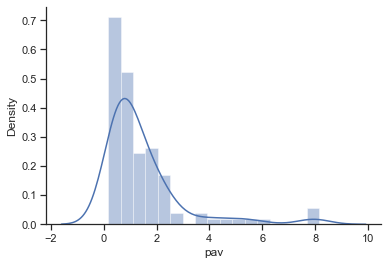

In [44]:
sns.distplot(mr_df.pav )

# dist of learning rate

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alpha', ylabel='Density'>

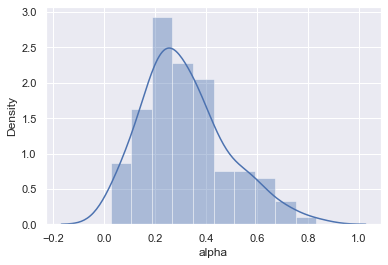

In [45]:
sns.distplot((mr_df.alpha), bins=10) 

# dist of go bias

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bias', ylabel='Density'>

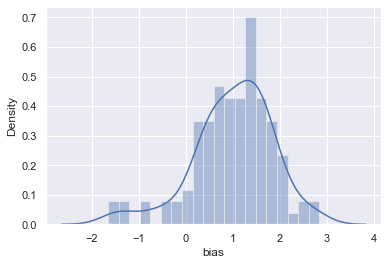

In [46]:
sns.distplot((mr_df.bias), bins=20) 

# dist of log(sensitivity to reward)

In [47]:
sns.distplot(((mr_df.beta)), bins=20) 

AttributeError: 'DataFrame' object has no attribute 'beta'

In [48]:
mr_perf = pd.merge(mr_df, final_performace_data, on='mturkID')
mr_perf['gw_ngw'] = mr_perf.go2win_second_session - mr_perf.nogo2win_second_session

mr_perf['non_par_pav'] = mr_perf.go2win_second_session + mr_perf.nogo2avoidPun_second_session - mr_perf.nogo2win_second_session - mr_perf.go2avoidPun_second_session

mr_perf['non_par_go_bias']  = mr_perf.go2win_second_session + mr_perf.go2avoidPun_second_session - mr_perf.nogo2win_second_session - mr_perf.nogo2avoidPun_second_session


<AxesSubplot:xlabel='bias', ylabel='nogo2win_second_session'>

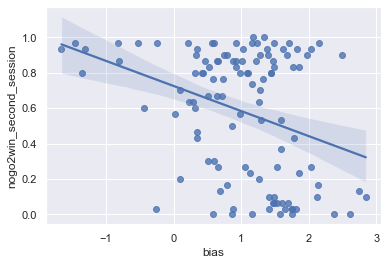

In [49]:
sns.regplot(x=('bias'), y='nogo2win_second_session', data = mr_perf)



# log(pav bias) & (g2win - nogo2win) performance 

<AxesSubplot:xlabel='pav', ylabel='non_par_pav'>

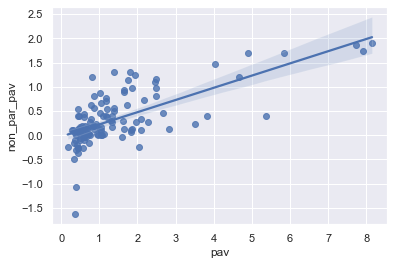

In [50]:
sns.regplot(y=('non_par_pav'), x='pav', data = mr_perf)

<AxesSubplot:xlabel='pav', ylabel='gw_ngw'>

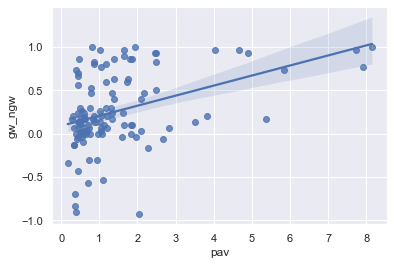

In [51]:
sns.regplot(x=('pav'), y='gw_ngw', data = mr_perf)

In [52]:
smf.ols(formula = 'non_par_pav ~ pav', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            non_par_pav   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     101.3
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           2.31e-17
Time:                        16:44:57   Log-Likelihood:                -57.167
No. Observations:                 114   AIC:                             118.3
Df Residuals:                     112   BIC:                             123.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0279      0.052     -0.533      0.595      -0.132       0.076
pav            0.2519      0.025     10.066      0.000       0.202       0.301
==============================================================================
Omnibus:                       15.053   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               33.928
Skew:                          -0.451   Prob(JB):                     4.29e-08
Kurtosis:                       5.516   Cond. No.                         3.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# learning rate & (g2win - nogo2win) performance 

<AxesSubplot:xlabel='alpha', ylabel='gw_ngw'>

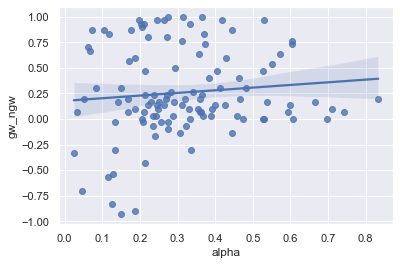

In [53]:
sns.regplot(x=(mr_perf['alpha']), y=mr_perf['gw_ngw'])

In [54]:
smf.ols(formula = 'gw_ngw ~ alpha', data = mr_perf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 gw_ngw   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.132
Date:                Mon, 19 Sep 2022   Prob (F-statistic):              0.290
Time:                        16:44:59   Log-Likelihood:                -64.977
No. Observations:                 114   AIC:                             134.0
Df Residuals:                     112   BIC:                             139.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1770      0.087      2.033      0.044       0.004       0.350
alpha          0.2598      0.244      1.064      0.290      -0.224       0.744
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.990   Jarque-Bera (JB):                0.077
Skew:                          -0.031   Prob(JB):                        0.962
Kurtosis:                       2.889   Cond. No.                         6.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
go_bias_pun_data = second_session_clean_data[second_session_clean_data.exp_stage == 'main_target_detection'][['mturkID','side', 'choice', 'outcome','exp_stage']]

In [56]:
def calc_go_prob(a):

    return sum(a.choice == 'go') / a.shape[0]

def stay_prob(a):
    return sum(a.is_stayed == True) / a.shape[0]

In [57]:
all_dfs = []
all_stay_dfs = []
all_act_out_dfs = []
for n,gp in go_bias_pun_data.groupby('mturkID'):
    df_subject = pd.DataFrame()
    df_subject_stay = pd.DataFrame()
    df_subject_act_out = pd.DataFrame()

    a = (gp)
    a['outcome_before'] = a.outcome.shift(1)
    a['choice_before'] = a.choice.shift(1)

    a['is_stayed'] = a.choice.shift(-1) == a.choice
    
    df_subject['go_prob'] = a.groupby('outcome_before').apply(calc_go_prob)
    df_subject = df_subject.reset_index()
    df_subject['mturkID'] = n

    df_subject_act_out['go_prob'] = a.groupby(['outcome_before','choice_before']).apply(calc_go_prob)
    df_subject_act_out = df_subject_act_out.reset_index()
    df_subject_act_out['mturkID'] = n
    

    df_subject_stay['stay_prob'] = a.groupby('outcome').apply(stay_prob)
    df_subject_stay = df_subject_stay.reset_index()
    df_subject_stay['mturkID'] = n

    all_dfs.append(df_subject)
    all_stay_dfs.append(df_subject_stay)
    all_act_out_dfs.append(df_subject_act_out)
datafram_stay = pd.concat(all_stay_dfs)
datafram_go_prob_pun = pd.concat(all_dfs)
datafram_go_prob_act_out = pd.concat(all_act_out_dfs)

datafram_go_prob_act_out['act_out']  = datafram_go_prob_act_out['choice_before'] + "+" + datafram_go_prob_act_out['outcome_before']

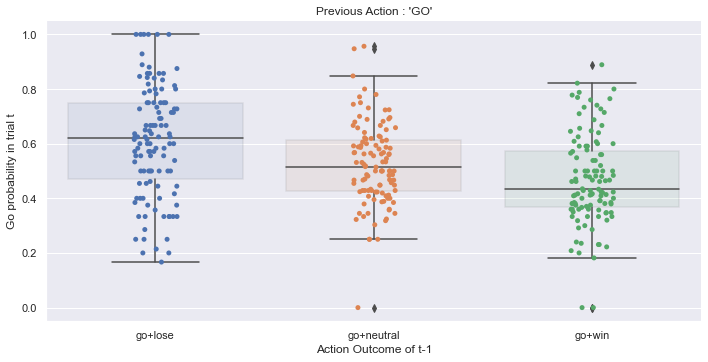

In [58]:
ax = sns.catplot(x="act_out", y="go_prob", data=datafram_go_prob_act_out[datafram_go_prob_act_out.choice_before == 'go'],height=5, aspect=2);
ax = sns.boxplot(x="act_out", y="go_prob", data= datafram_go_prob_act_out[datafram_go_prob_act_out.choice_before == 'go'] , boxprops=dict(alpha=.1));

ax.set(xlabel="Action Outcome of t-1", ylabel = "Go probability in trial t", title = "Previous Action : 'GO'")
plt.show()

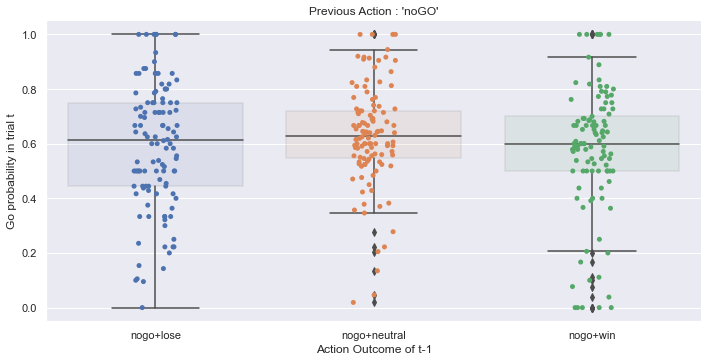

In [59]:
ax = sns.catplot(x="act_out", y="go_prob", data=datafram_go_prob_act_out[datafram_go_prob_act_out.choice_before == 'nogo'],height=5, aspect=2);
ax = sns.boxplot(x="act_out", y="go_prob", data= datafram_go_prob_act_out[datafram_go_prob_act_out.choice_before == 'nogo'] , boxprops=dict(alpha=.1));

ax.set(xlabel="Action Outcome of t-1", ylabel = "Go probability in trial t", title = "Previous Action : 'noGO'")
plt.show()

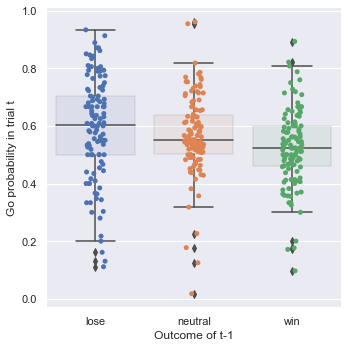

In [60]:
ax = sns.catplot(x="outcome_before", y="go_prob", data=datafram_go_prob_pun);
ax = sns.boxplot(x="outcome_before", y="go_prob", data= datafram_go_prob_pun , boxprops=dict(alpha=.1));

ax.set(xlabel="Outcome of t-1", ylabel = "Go probability in trial t")
plt.show()

[(0.45, 0.7)]

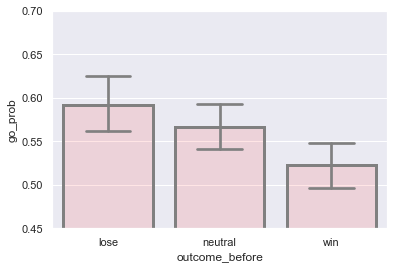

In [77]:
ax = sns.barplot(x="outcome_before", y="go_prob", data= datafram_go_prob_pun,
#  errorbar=("pi", 50), 
  ci=95,
  capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(1, 0, 0, 0.1),
) 

ax.set(ylim=(0.45, 0.7))


AttributeError: 'Rectangle' object has no property 'errorbar'

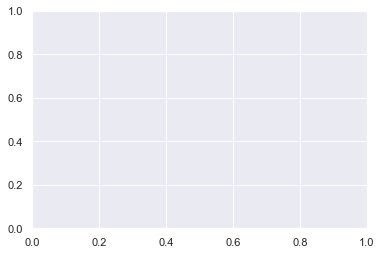

In [63]:
ax = sns.barplot(x="outcome_before", y="go_prob", data= datafram_go_prob_pun , errorbar="sd");

# ax.set(xlabel="Outcome of t-1", ylabel = "Go probability in trial t")
plt.show()

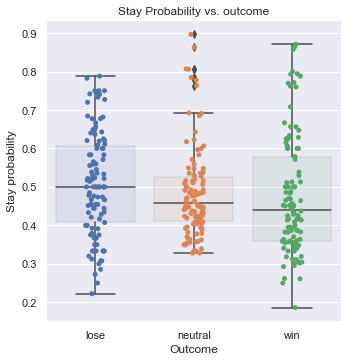

In [61]:
ax = sns.catplot(x="outcome", y="stay_prob", data=datafram_stay);
ax = sns.boxplot(x="outcome", y="stay_prob", data= datafram_stay , boxprops=dict(alpha=.1));

ax.set(xlabel="Outcome", ylabel = "Stay probability", title="Stay Probability vs. outcome")
plt.show()

In [32]:
model = smf.ols('stay_prob ~ C(outcome) ',
            data=datafram_stay).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
(result)

,df,sum_sq,mean_sq,F,PR(>F)
C(outcome),2.0,0.068000,0.034000,1.884837,0.153442
Residual,339.0,6.115116,0.018039,NaN,NaN


In [30]:
model = smf.ols('go_prob ~ C(outcome_before) ',
            data=datafram_go_prob_pun).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
(result)

,df,sum_sq,mean_sq,F,PR(>F)
C(outcome_before),2.0,0.277771,0.138885,6.120464,0.002448
Residual,339.0,7.692575,0.022692,NaN,NaN
